In [ ]:
!pip install gdown
!gdown -O question.zip --id 13lgLGcCQXv9bo2z-ZBjSmC_AZoGLh2XX
!unzip question.zip

In [17]:
!gdown -O questionv2.zip --id 1DYOMqWhEP_RV1NymPE3b7dXuneAjC7yp
!gdown -O questionv3.zip --id 1Lg--KBEFK4GBTEg2o-Ql9nDmh8guKBtw
!unzip questionv2 
!unzip questionv3

NotImplementedError: ignored

# Env

In [ ]:
!pip install super-gradients==3.1.0
!pip install imutils

# **Training**

In [1]:
#@title category map
category_map = {
    "heading": 0, 
    "question": 1,  
    "subquestion": 2,
    "choice"  : 3,
    "image"   : 4,
    "table"   : 5,
    "blank"   : 6,
    "auxillary_text"   : 7
}
category_weights = {
    "heading": 3, 
    "question": 2,  
    "subquestion": 1,
    "choice"  : 0,
    "image"   : 0,
    "table"   : 0,
    "blank"   : 0,
    "auxillary_text"   : 0
}
reverse_map = {category_map[k]:k for k in category_map}

## prepare dataset

In [2]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-05-10 09:48:37] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-10 09:48:48] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-10 09:48:48] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-10 09:48:48] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-10 09:48:48] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:
dataset_params = {
    'data_dir':'/content/content/QuestFormCoco',
    'train_images_dir':'images/train',
    'train_labels_dir':'labels/train',
    'val_images_dir':'images/val',
    'val_labels_dir':'labels/val',
    'test_images_dir':'images/test',
    'test_labels_dir':'labels/test',
    'classes': ['heading', 'question', 'subquestion', 'choice', "image", "table", "blank", "auxillary_text"]
}

In [4]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [11]:
train_data.dataset.transforms
train_data.dataset.dataset_params['transforms'][1]
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

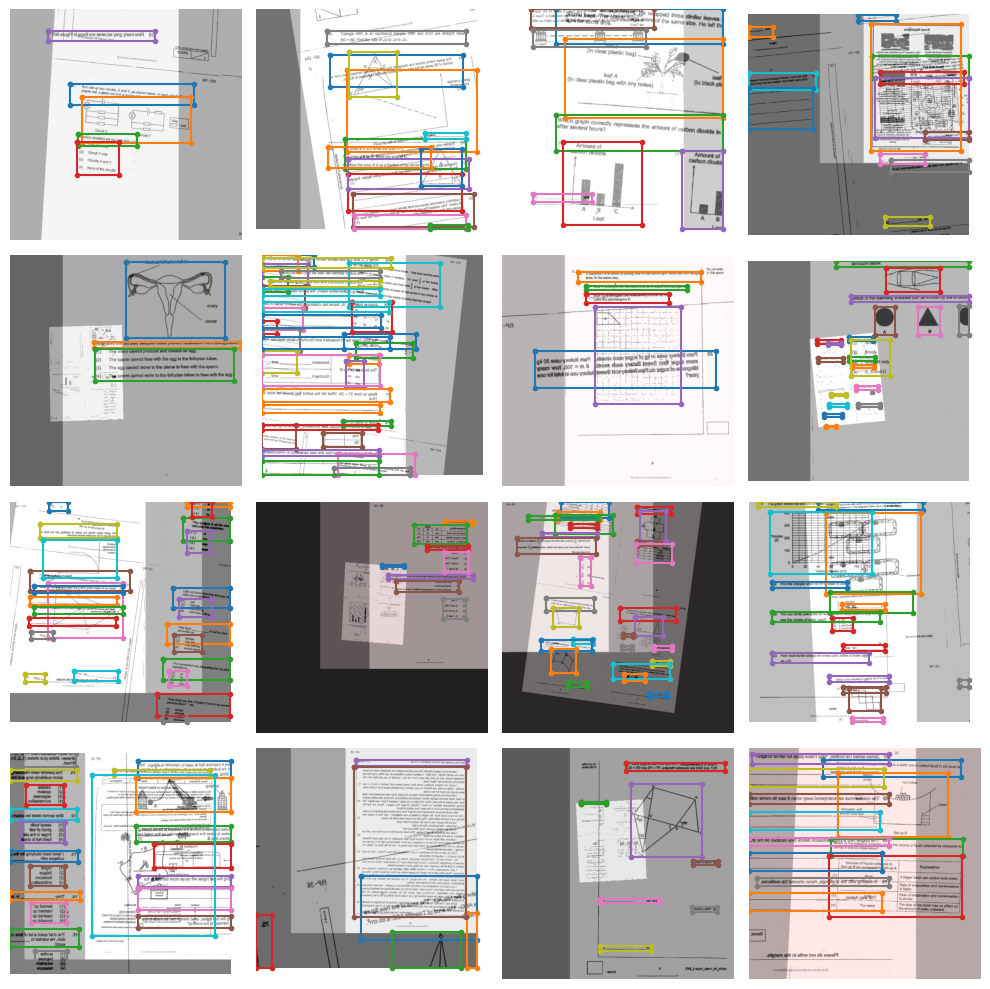

In [12]:
train_data.dataset.plot()

## 👩🏽‍🦳 Instantiating the model

You saw how to instantiate the model for inference earlier. 

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [5]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-10 09:49:17] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


  0%|          | 0.00/256M [00:00<?, ?B/s]

# 🎛️ **Training parameters**

You need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub. 

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [6]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 50 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [8]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/content/runs'
trainer = Trainer(experiment_name='yolonas_l', ckpt_root_dir=CHECKPOINT_DIR)

In [9]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-10 09:50:02] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-05-10 09:50:11] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to /content/runs/yolonas_l/console_May10_09_50_12.txt


[2023-05-10 09:50:26] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 686        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         42         (len(train_loader))
    - Gradient updates per epoch:   42         (len(train_loader) / batch_accumulate)

[2023-05-10 09:53:16] INFO - base_sg_logger.py - Checkpoint saved in /content/runs/yolonas_l/ckpt_best.pth
[2023-05-10 09:53:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0010637884261086583
[2023-05-10 09:56:10] INFO - base_sg_logger.py - Checkpoint saved in /content/

# EVALUATE

In [20]:
# best_model = models.get('yolo_nas_l',
#                         num_classes=len(dataset_params['classes']),
#                         checkpoint_path="/content/runs/yolonas_l/average_model.pth")
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/runs/yolonas_l/ckpt_best.pth")

In [21]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300,nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 6/6 [00:08<00:00,  1.18it/s]

{'PPYoloELoss/loss_cls': 0.8073901,
 'PPYoloELoss/loss_iou': 0.116449,
 'PPYoloELoss/loss_dfl': 0.6681685,
 'PPYoloELoss/loss': 1.4325969,
 'Precision@0.50': tensor(0.0676),
 'Recall@0.50': tensor(0.9814),
 'mAP@0.50': tensor(0.8650),
 'F1@0.50': tensor(0.1232)}

In [24]:
img_url = '/content/content/QuestFormCoco/images/test/P6_Science_2022_SA2_chij.pdf_26.jpg'
import time
st = time.time()
x = best_model.predict(img_url)
print(time.time()-st)


0.0454099178314209


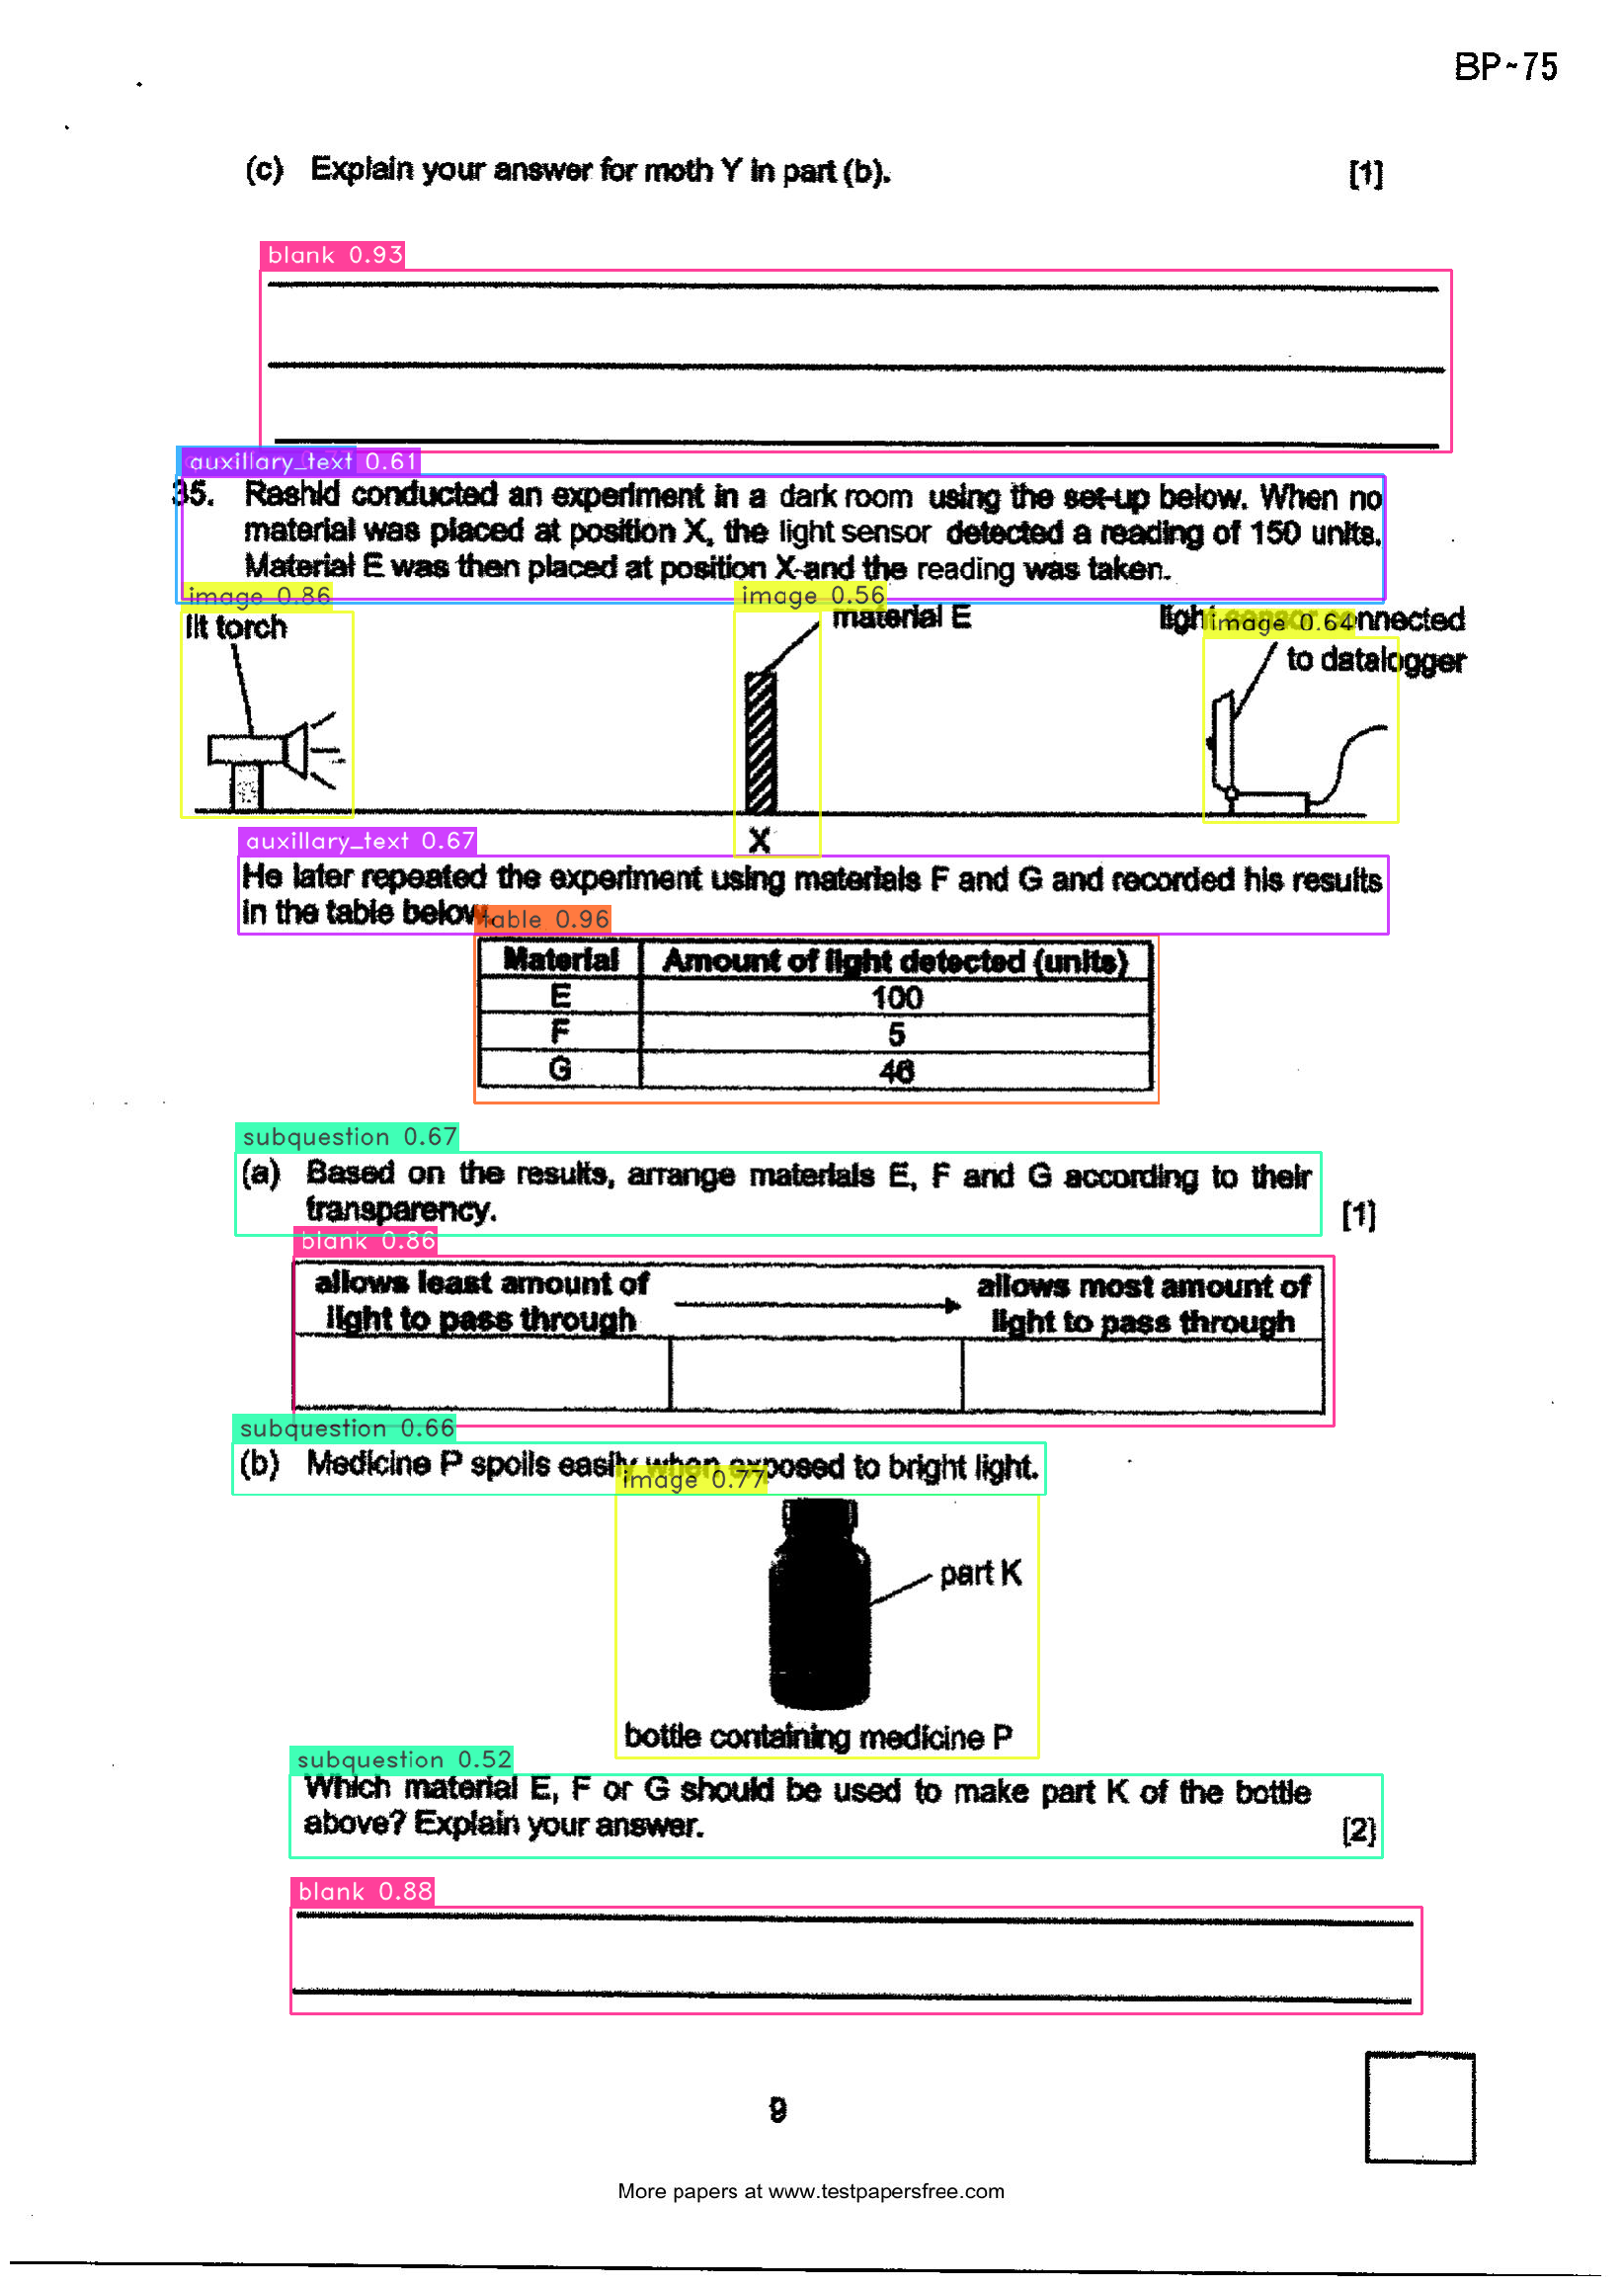

In [25]:
x.show()

In [26]:
x.save()

ImagesDetectionPrediction(_images_prediction_lst=<generator object Pipeline._generate_prediction_result at 0x7f3ac0851c40>)

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature. 

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).